# LCC-Server setup notes

This notebook discusses how to set up an [LCC-Server](https://github.com/waqasbhatti/lcc-server) instance for a collection of light curves. The example light curves used here are available at:

- <https://wbhatti.org/abfiles/lcc-server-demo.tar.gz> 
- (20 MB, SHA256SUM: `04be2a0467d832ca5f7edb6879962c84db3993771ad8ce5c7e7eaccf35723435`)

We will go through the following items:

- [writing a Python module and function to read your light curves](#Preparing-your-light-curves)
- [preparing the LCC-Server base directory](#Preparing-the-LCC-Server-base-directory)
- [importing your light curves into an LC collection](#Importing-your-light-curves)
- [preparing checkplot pickles to add extra catalog information](#Preparing-and-importing-checkplot-pickles)
- [running the LCC-Server](#Running-the-LCC-Server)

The LCC-Server relies on the [astrobase](https://github.com/waqasbhatti/astrobase) package for much of its functionality, especially the 'checkplot pickles' generated from light curves using the [astrobase.checkplot.checkplot_pickle](https://astrobase.readthedocs.io/en/latest/astrobase.checkplot.pkl.html#astrobase.checkplot.pkl.checkplot_pickle) function or one of its higher-level wrappers: [astrobase.lcproc.runcp](https://astrobase.readthedocs.io/en/latest/astrobase.lcproc.checkplotgen.html#astrobase.lcproc.checkplotgen.runcp) or [astrobase.lcproc.parallel_cp](https://astrobase.readthedocs.io/en/latest/astrobase.lcproc.checkplotgen.html#astrobase.lcproc.checkplotgen.parallel_cp). A short introduction to the checkplot pickle concept is provided in the [lightcurves-and-checkplots notebook](https://github.com/waqasbhatti/astrobase-notebooks/blob/master/lightcurves-and-checkplots.ipynb) ([Jupyter nbviewer link](https://nbviewer.jupyter.org/github/waqasbhatti/astrobase-notebooks/blob/master/lightcurves-and-checkplots.ipynb)), and a far more detailed version is presented in the [lc-collection-work](https://github.com/waqasbhatti/astrobase-notebooks/blob/master/lc-collection-work.ipynb) ([Jupyter nbviewer link](https://nbviewer.jupyter.org/github/waqasbhatti/astrobase-notebooks/blob/master/lc-collection-work.ipynb)) notebook. 

If you have light curves that were already processed through the functions outlined there and have generated checkplot pickles, you can skip down to the [LCC-Server base directory preparation](#Preparing-the-LCC-Server-base-directory) section. If not, the next section outlines how to write a Python module containing a function to read your light curves into a format that astrobase and LCC-Server can understand and work with. This will then enable automatic generation of basic checkplot pickles that can be used as the basis of the server's catalogs.

## Preparing your light curves

We'll be using example light curves that are in a simple text format. These look something like:

```
rjd,stf,xcc,ycc,aim_000,aie_000,aim_001,aie_001,aim_002,aie_002,aep_000,aep_001,aep_002
54809.0746065,9,1267.787,877.217,11.37799,0.00421,11.43704,0.00374,11.45887,0.00359,11.49946,11.49882,11.50113
54809.0786921,9,1319.465,888.06,11.42377,0.00431,11.46128,0.0038,11.47978,0.00364,11.48983,11.48822,11.49355
54809.0827546,9,1320.227,889.038,11.52475,0.00451,11.53167,0.00391,11.52608,0.00369,11.50115,11.49696,11.49535
54809.0868056,9,1320.013,886.0,11.43081,0.00428,11.46243,0.00375,11.47395,0.00356,11.47891,11.4879,11.49395
54809.0907292,9,1320.923,884.219,11.42521,0.00426,11.46114,0.00374,11.46823,0.00354,11.50647,11.50872,11.50514
54809.0946875,9,1322.157,879.114,11.47178,0.00436,11.48658,0.00379,11.48964,0.00359,11.49252,11.49508,11.5004
54809.0986574,9,1323.018,878.145,11.41705,0.00433,11.44548,0.0038,11.45548,0.00363,11.4982,11.50094,11.50138
54809.102581,9,1324.09,873.883,11.43568,0.00435,11.46572,0.00382,11.47577,0.00365,11.47914,11.49503,11.49835
54809.1065046,9,1325.172,873.507,11.31651,0.0041,11.40322,0.0037,11.44349,0.00359,11.5019,11.4997,11.50298
```

The first line is the column names while the rest of the file is CSV format. There are three magnitude apertures in use here: `000`, `001`, `002` The columns are:

- rjd: the reduced Julian date
- stf: the telescope ID of the observing instrument
- xcc: the X coordinate of the object on the CCD
- ycc: the Y coordinate of the object on the CCD
- aim_{aperturecol}: the instrumental raw magnitude in each aperture 000, 001, 002
- aie_{aperturecol}: the photometric error associated with the instrumental raw mag in aperture 000, 001, 002
- aep_{aperturecol}: the External Parameter Decorrelated (EPD) magnitude in aperture 000, 001, 002

We'll also need a object catalog that has basic information for each object that we have light curves for. This looks something like:

```
objectid|ra|decl|jmag|hmag|kmag|ndet|observatory|telescope|lcfilename
HAT-215-0001809|61.681917|30.444036|9.725|9.26|9.125|11901|HATNet|HN07,HN08|HAT-215-0001809-lc.csv
HAT-215-0004605|67.373792|26.281448|10.34|9.675|9.388|6260|HATNet|HN07,HN08,HN10|HAT-215-0004605-lc.csv
HAT-215-0005039|62.245702|30.006277|11.103|10.838|10.701|9457|HATNet|HN07,HN08|HAT-215-0005039-lc.csv
HAT-215-0005050|67.397499|28.891775|10.399|9.64|9.387|6265|HATNet|HN07,HN08,HN10|HAT-215-0005050-lc.csv
HAT-215-0010422|67.828296|27.993004|11.868|11.48|11.334|6261|HATNet|HN07,HN08,HN10|HAT-215-0010422-lc.csv
HAT-215-0012059|60.128998|30.906244|12.11|11.689|11.607|11881|HATNet|HN07,HN08|HAT-215-0012059-lc.csv
HAT-215-0013494|67.340183|31.636814|11.956|11.348|11.2|6255|HATNet|HN07,HN08,HN10|HAT-215-0013494-lc.csv
HAT-215-0013882|62.095389|29.233021|12.05|11.521|11.355|11922|HATNet|HN07,HN08,HN09|HAT-215-0013882-lc.csv
HAT-215-0016025|62.790491|29.722546|12.491|12.156|12.017|3671|HATNet|HN07,HN08|HAT-215-0016025-lc.csv
```

The minimum information required for each object to use its light curve in all astrobase and LCC-Server functions is:

- objectid: some object identifier string
- ra: the right ascension of the object in decimal degrees
- decl: the declination of the object in decimal degrees
- ndet: the number of observations for this object

All other information is optional, but if you have catalog magnitudes, this will allow LCC-Server to calculate colors, reddening, and rough object classifications based on SDSS/SEGUE and 2MASS JHK color cuts. 

Let's now get the example data:

In [1]:
pwd

'/Users/waqasbhatti/mycode/astrobase-notebooks'

In [2]:
# wget the LCs when this cell is run
!wget https://wbhatti.org/abfiles/lcc-server-demo.tar.gz

--2019-03-09 13:08:37--  https://wbhatti.org/abfiles/lcc-server-demo.tar.gz
Resolving wbhatti.org (wbhatti.org)... 173.255.226.56, 2600:3c03::f03c:91ff:fedf:d8fd
Connecting to wbhatti.org (wbhatti.org)|173.255.226.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19986619 (19M) [application/octet-stream]
Saving to: ‘lcc-server-demo.tar.gz’

lcc-server-demo.tar 100%[===================>]  19.06M  10.3MB/s    in 1.8s    

2019-03-09 13:08:39 (10.3 MB/s) - ‘lcc-server-demo.tar.gz’ saved [19986619/19986619]



In [3]:
ls

LICENSE			  lightcurve-work.ipynb
README.md		  lightcurves-and-checkplots.ipynb
lc-collection-work.ipynb  nb-data/
lcc-server-demo.tar.gz	  requirements.txt
lcc-server-setup.ipynb


In [ ]:
# untar the tarball
!tar xvf lcc-server-demo.tar.gz

In [5]:
ls lcc-server-demo

lcformat-description.json  lcreadermodule.py  lightcurves/  object-db.csv


In [11]:
# let's read in the object-db.csv file and turn it into a Numpy record array
import numpy as np

objectdb = np.genfromtxt('lcc-server-demo/object-db.csv',
                         names=True,
                         dtype='U20,f8,f8,f8,f8,f8,i8,U20,U20,U60',
                         delimiter='|',
                         autostrip=True)

In [12]:
# take a peek at the object database file
objectdb[:3]

array([('HAT-215-0001809', 61.681917, 30.444036,  9.725,  9.26 ,  9.125, 11901, 'HATNet', 'HN07,HN08', 'HAT-215-0001809-lc.csv'),
       ('HAT-215-0004605', 67.373792, 26.281448, 10.34 ,  9.675,  9.388,  6260, 'HATNet', 'HN07,HN08,HN10', 'HAT-215-0004605-lc.csv'),
       ('HAT-215-0005039', 62.245702, 30.006277, 11.103, 10.838, 10.701,  9457, 'HATNet', 'HN07,HN08', 'HAT-215-0005039-lc.csv')],
      dtype=[('objectid', '<U20'), ('ra', '<f8'), ('decl', '<f8'), ('jmag', '<f8'), ('hmag', '<f8'), ('kmag', '<f8'), ('ndet', '<i8'), ('observatory', '<U20'), ('telescope', '<U20'), ('lcfilename', '<U60')])

In [13]:
# look at the column names in the object DB
objectdb.dtype.names

('objectid',
 'ra',
 'decl',
 'jmag',
 'hmag',
 'kmag',
 'ndet',
 'observatory',
 'telescope',
 'lcfilename')

We need to write a function to read these light curves. This function will produce a dict, which we call an 'lcdict', that MUST have the form below for it to be readable using astrobase and LCC-Server functions:

```
{
  'objectid': 'your object ID' (required),
  'objectinfo': {'ra': right ascension in decimal deg (required),
                 'decl': declination in decimal deg (required),
                 'ndet': number of observations (required),
                 ... other optional objectinfo keys and values},
  'columns': ['time_col_name', 'mag_col_name', 'err_col_name'], list of column keys in the lcdict (required),
  'time_col_name': a numpy array of time values (required),
  'mag_col_name': a numpy array of mag or flux values (required),
  'err_col_name': a numpy array of err values for each mag/flux (required),
  ... other mag or metadata columns
}
```

The following may be useful when generating your lcdicts:
- [the default list of all lcdict keys recognized by astrobase](https://github.com/waqasbhatti/lcc-server/blob/f192aa4b7f4a52d7510d29f1c14a570728717731/lccserver/cli.py#L549) and [some details on the format](https://github.com/waqasbhatti/lcc-server/blob/f192aa4b7f4a52d7510d29f1c14a570728717731/lccserver/cli.py#L722)
- [the default list of all objectinfo keys considered as magnitude values by astrobase](https://github.com/waqasbhatti/astrobase/blob/f4ac4fc308ee8473de0ec9d57dd97db82b04b927/astrobase/varclass/starfeatures.py#L333)

Let's write up the function to read the example light curves now.

In [14]:
import os.path
import numpy as np

def read_objectcatalog(objectinfo_catalog):
    '''
    This just reads in the object catalog into a recarray.
    
    '''
    return np.genfromtxt(objectinfo_catalog,
                         names=True,
                         dtype='U20,f8,f8,f8,f8,f8,i8,U20,U20,U60',
                         delimiter='|',
                         autostrip=True)


def read_lightcurve(lcfile, objectinfo_catalog=None):
    '''
    This reads in a light curve into an lcdict.
    
    lcfile: path to the light curve file to read
    objectinfo_catalog: path to the object-db.csv file or the prepared record array from that file.
    
    Returns an lcdict in the required format.
    
    '''
    
    # get the object catalog first
    if isinstance(objectinfo_catalog, str) and os.path.exists(objectinfo_catalog):
        objcat = read_objectcatalog(objectinfo_catalog)
    elif isinstance(objectinfo_catalog, np.ndarray):
        objcat = objectinfo_catalog
    else:
        print("no object info catalog provided, can't continue...")
        return
    
    # look up the filename that we're reading in
    objectinfo_ind = objcat['lcfilename'] == os.path.basename(lcfile)
    
    # prepare the objectinfo dict
    objectinfo_dict = {}
    for x in objcat.dtype.names:
        objectinfo_dict[x] = np.asscalar(objcat[x][objectinfo_ind])
    
    # read the light curve file
    lcdata = np.genfromtxt(
        lcfile, 
        names=True,
        dtype='f8,i8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8',
        delimiter=','
    )
    
    columns = lcdata.dtype.names
    
    # the initial lcdict
    lcdict = {
        'objectid':objectinfo_dict['objectid'],
        'objectinfo':objectinfo_dict,
        'columns':columns
    }
    
    # turn the columns into separate ndarrays
    for col in columns:
        lcdict[col] = lcdata[col]
        
    return lcdict

In [15]:
# let's see if it works
lcdict = read_lightcurve('lcc-server-demo/lightcurves/HAT-215-0005050-lc.csv',
                         objectinfo_catalog='lcc-server-demo/object-db.csv')

In [16]:
# looks OK
lcdict

{'objectid': 'HAT-215-0005050',
 'objectinfo': {'objectid': 'HAT-215-0005050',
  'ra': 67.397499,
  'decl': 28.891775,
  'jmag': 10.399,
  'hmag': 9.64,
  'kmag': 9.387,
  'ndet': 6265,
  'observatory': 'HATNet',
  'telescope': 'HN07,HN08,HN10',
  'lcfilename': 'HAT-215-0005050-lc.csv'},
 'columns': ('rjd',
  'stf',
  'xcc',
  'ycc',
  'aim_000',
  'aie_000',
  'aim_001',
  'aie_001',
  'aim_002',
  'aie_002',
  'aep_000',
  'aep_001',
  'aep_002'),
 'rjd': array([54390.9583449, 54390.9630093, 54390.9669444, ..., 54557.6648148,
        54557.6688542, 54558.6361111]),
 'stf': array([10, 10, 10, ..., 10, 10, 10]),
 'xcc': array([1698.422, 1656.161, 1654.986, ..., 1654.266, 1654.951, 1573.145]),
 'ycc': array([3578.221, 3572.151, 3571.717, ..., 3567.112, 3568.715, 3534.205]),
 'aim_000': array([13.46215, 13.47645, 13.46247, ..., 13.32079, 13.25246, 13.87421]),
 'aie_000': array([0.02014, 0.02156, 0.02041, ..., 0.01732, 0.01697, 0.03012]),
 'aim_001': array([13.3502 , 13.34854, 13.35258, .

Next, we'll write a Python module that contains this function. This module and the LC reader function will be dynamically imported by astrobase and LCC-Server to read your light curves. 

The module can optionally contain a function that will normalize your light curves' magnitude or flux values if necessary. This function should take the lcdict produced by your LC reader function and return it when done. Normalization is often useful if you're dealing with a long-running variable star survey that has observations in different filters or telescope configurations. Normalizing the light curve will remove systematic offsets in magnitude/flux caused by these differences. To see examples of these, see [astrobase.hatsurveys.hatlc.normalize_lcdict](https://astrobase.readthedocs.io/en/latest/astrobase.hatsurveys.hatlc.html#astrobase.hatsurveys.hatlc.normalize_lcdict) and [astrobase.hatsurveys.hatlc.normalize_lcdict_byinst](https://astrobase.readthedocs.io/en/latest/astrobase.hatsurveys.hatlc.html#astrobase.hatsurveys.hatlc.normalize_lcdict_byinst).

Here's the code for the file we'll be writing (this is also available in the downloaded lcc-server-demo.tar.gz file):

In [17]:
%%writefile lcreadermodule.py
#!/usr/bin/env python

import os.path
import numpy as np

# this is a generic LC normalization function
# https://astrobase.readthedocs.io/en/latest/astrobase.lcmath.html#astrobase.lcmath.normalize_magseries
from astrobase.lcmath import normalize_magseries

# a function that is used by the LC reader function
def read_objectcatalog(objectinfo_catalog):
    '''
    This just reads in the object catalog into a recarray.
    
    '''
    return np.genfromtxt(objectinfo_catalog,
                         names=True,
                         dtype='U20,f8,f8,f8,f8,f8,i8,U20,U20,U60',
                         delimiter='|',
                         autostrip=True)


# example of a LC reader function
# any kwargs can be specified fully later when telling the LCC-Server about this function
# e.g., we might want to call this all the time with objectinfo_catalog='object-db.csv'
# for our example here
def read_lightcurve(lcfile, 
                    objectinfo_catalog=None):
    '''
    This reads in a light curve into an lcdict.
    
    lcfile: path to the light curve file to read
    objectinfo_catalog: path to the object-db.csv file or the prepared record array from that file.
    
    Returns an lcdict in the required format.
    
    '''
    
    # get the object catalog first
    if isinstance(objectinfo_catalog, str) and os.path.exists(objectinfo_catalog):
        objcat = read_objectcatalog(objectinfo_catalog)
    elif isinstance(objectinfo_catalog, np.ndarray):
        objcat = objectinfo_catalog
    else:
        print("no object info catalog provided, can't continue...")
        return
    
    # look up the filename that we're reading in
    objectinfo_ind = objcat['lcfilename'] == os.path.basename(lcfile)
    
    # prepare the objectinfo dict
    objectinfo_dict = {}
    for x in objcat.dtype.names:
        objectinfo_dict[x] = np.asscalar(objcat[x][objectinfo_ind])
    
    # read the light curve file
    lcdata = np.genfromtxt(
        lcfile, 
        names=True,
        dtype='f8,i8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8,f8',
        delimiter=','
    )
    
    columns = lcdata.dtype.names
    
    # the initial lcdict
    lcdict = {
        'objectid':objectinfo_dict['objectid'],
        'objectinfo':objectinfo_dict,
        'columns':columns
    }
    
    # turn the columns into separate ndarrays
    for col in columns:
        lcdict[col] = lcdata[col]
        
    return lcdict


# example of a normalization function
# any kwargs can be specified fully when telling the LCC-Server about this function
# e.g., we might want to call this all the time with 
# timecol='rjd', magcol='aep_000' for our example here
def normalize_lcdict(lcdict, timecol=None, magcol=None):
    '''
    This normalizes the input lcdict using an astrobase function.
    
    timecol, magcol are the columns to use in this operation.
    
    You must write your changes back to the lcdict and return it.
    
    '''
    
    if timecol and magcol:
        normalized_times, normalized_mags = normalize_magseries(lcdict['rjd'], lcdict['aep_000'])
        if normalized_times is not None and normalized_mags is not None:
            lcdict[timecol] = normalized_times
            lcdict[magcol] = normalized_mags
        
    return lcdict

Writing lcreadermodule.py


In [18]:
# import this new module
import lcreadermodule

In [19]:
lcdict = lcreadermodule.read_lightcurve('lcc-server-demo/lightcurves/HAT-215-0005050-lc.csv', 
                                        objectinfo_catalog='lcc-server-demo/object-db.csv')

In [20]:
normalized_lcdict = lcreadermodule.normalize_lcdict(lcdict)

In [21]:
# everything looks OK
normalized_lcdict['rjd'], normalized_lcdict['aep_000'], normalized_lcdict['aie_000']

(array([54390.9583449, 54390.9630093, 54390.9669444, ..., 54557.6648148,
        54557.6688542, 54558.6361111]),
 array([13.27634, 13.2561 , 13.25552, ..., 13.21489, 13.26916, 13.26748]),
 array([0.02014, 0.02156, 0.02041, ..., 0.01732, 0.01697, 0.03012]))

Now that we've demonstrated that we can turn our CSV light curves into LCC-Server friendly lcdicts, let's proceed to setting up the base directory for the server.

## Preparing the LCC-Server base directory

The LCC-Server comes with a command-line-interface (CLI) script called `lcc-server` that will be available in your `$PATH` after you install the `lccserver` package using `pip install lccserver` or a similar command (see the [installation notes](https://github.com/waqasbhatti/lcc-server#installation)).

This looks something like the following:

```
(venv) $ lcc-server --help
usage: lcc-server [-h] [--basedir BASEDIR]
                  {init-basedir,add-collection,edit-collection,del-collection,run-server,shell}

The LCC-Server CLI

positional arguments:
  {init-basedir,add-collection,edit-collection,del-collection,run-server,shell}
                        COMMAND to run

optional arguments:
  -h, --help            show this help message and exit
  --basedir BASEDIR     The base directory to run commands in. This is the
                        current directory by default:
                        /Users/waqasbhatti/mycode/astrobase-notebooks

COMMAND is one of:

init-basedir        -> Initializes the basedir for the LCC-Server.
                       This is an interactive command.

add-collection      -> Adds an LC collection to the LCC-Server.
                       This is an interactive command.

edit-collection     -> Edits an existing LC collection.
                       This is an interactive command.

del-collection      -> Removes an LC collection from the LCC-Server
                       This will ask you for confirmation.

run-server          -> Runs an instance of the LCC-Server to provide
                       the main search interface and a backing instance
                       of the checkplotserver for serving objectinfo.

shell               -> Starts an IPython shell in the context of the specified
                       LCC-Server base directory. This is useful for debugging
                       and running queries directly using the
                       lccserver.backend.datasets.py and
                       lccserver.backend.dbsearch.py modules.
```

The command we're going to use now is `init-basedir`. Let's check where we are at the moment:

In [22]:
pwd

'/Users/waqasbhatti/mycode/astrobase-notebooks'

In [23]:
ls

LICENSE			  lcc-server-setup.ipynb
README.md		  lcreadermodule.py
__pycache__/		  lightcurve-work.ipynb
lc-collection-work.ipynb  lightcurves-and-checkplots.ipynb
lcc-server-demo/	  nb-data/
lcc-server-demo.tar.gz	  requirements.txt


Let's set up a LCC-Server `basedir` in a sub-directory of the current directory called `lcc`. This will start an interactive prompt session where you can answer some questions about your project. Most of this information goes into the footer of the LCC-Server's web pages.

Any question can be answered with its default value by hitting the Enter key.

```
(venv) $ lcc-server --basedir lcc init-basedir
```

Type in a project name to use:
```
Project name [default: Example Project]: LCC Server demo project
```

Type in a project URL if any:
```
Project URL [default: https://example.org/astro/project]:
```

Type in a department name:
```
Department [default: Department of Astronomy]:
```

Type in a URL for the department if any:
```
URL for the department [default: https://example.org/astro]:
```

Type in the institution name:
```
Institution [default: Example University]:
```

Type in a URL for the institution if any:

```
URL for the institution [default: https://example.org]:
```

Type in the file path to a logo image file to use for the institution logo:
```
Path to an institution logo image file [default: None]:
```

Finally, this will do some work and return something like so:
```
[I 190309 13:20:12 cli:192] Created LCC-Server sub-directories under basedir: lcc
[I 190309 13:20:12 cli:263] Created site-info.json: lcc/site-info.json
[I 190309 13:20:12 cli:264] Please review this file and fill in details as appropriate.
[I 190309 13:20:12 cli:265] Edit the file pointed to by the 'email_settings_file' key in site-info.json to set up an email server (for notifications, etc.).
[I 190309 13:20:12 cli:298] Created doc-index.json: lcc/docs/doc-index.json and barebones lcc/docs/citation.md, lcc/docs/lcformat.md
[I 190309 13:20:12 cli:306] No existing authentication DB found, making a new one...
```

At this point, the command will pause and ask you for an admin user email address and password. You can hit Enter to accept the default values or type these in. We'll accept the default values for now.

```
Admin email address [default: waqasbhatti@localhost]:
Admin password [default: randomly generated]:

[W 190309 13:22:48 cli:352] Generated random admin password: rdMeI1XUz2uq3vjkh6TmGg

[I 190309 13:22:48 cli:369] Generating LCC-Server secret tokens...
[I 190309 13:22:48 cli:393] Done with LCC-Server basedir set up for: /Users/waqasbhatti/mycode/astrobase-notebooks/lcc.
```

You can use these credentials to perform administrative operations such as editing the site-info.json file, editing datasets, changing user details, etc. from an admin web interface instead of editing the config files on disk. To enable logins and user sign-ups for the LCC-Server, however, you will need a working email server. We'll talk about this below.

For now, let's look at the directory structure and files that this command created:

In [26]:
!tree --dirsfirst -a lcc

lcc
├── csvlcs
├── datasets
├── docs
│   ├── static
│   ├── citation.md
│   ├── doc-index.json
│   └── lcformat.md
├── lccjsons
├── products
├── .authdb.sqlite
├── .lccserver.secret
├── .lccserver.secret-cpserver
├── .lccserver.secret-email
├── .lccserver.secret-fernet
├── lcc-datasets.sqlite
├── lcc-index.sqlite
└── site-info.json

6 directories, 11 files


The directories and files are all used in the LCC-Server installation.

### `csvlcs`

This directory contains the output light curves generated after your original LC format is converted to LCC-Server's standard CSV text format. This allows you to serve and search through collections of light curves from many different projects under one interface. The format and Python modules functions to read it are described in full at: https://github.com/waqasbhatti/lcc-server/blob/master/lccserver/server-docs/csvlc.md. 

### `datasets` 

Results of searches produce *datasets*, a permanent record of the search parameters and the objects matching these. Datasets are generated in Python pickle format using the filename scheme: `dataset-[setid].pkl.gz` where `setid` is a random alphanumeric identifier. This then translates to these datasets being available over HTTP at the permanent URL `http://your.lccserver.org/set/[setid]`. Ancillary products of datasets include a CSV for the data table of the search results: `dataset-[setid].csv` that goes into the `datasets` directory, and a ZIP file of light curves of all objects matching the search parameters that goes into the `products` directory as `lightcurves-[setid].zip`.

### `docs`

This is the 'Site Documentation' directory for information specific to your project. The LCC-Server has its own docs that explain how to use the browser and API, and it searches in this directory for any additional docs it needs to serve. You can write anything in Markdown files under this directory, update the `doc-index.json` file with your file's name (without the `.md` extension) and a title for the document. It will then show up automatically in the `http://your.lccserver.org/docs` page under the **Hosted light curve collections** heading. The `doc-index.json` file that is auto-generated here points to some useful documents that you can fill in to get started:

```json
{
  "citation": "Citing the data available on this server",
  "lcformat": "Light curve columns and metadata description"
}
```

The `static` sub directory in the `docs` directory can be used to put in any images, etc. you want to link to from your Site Documentation. When writing your 'Site Documentation' files, you can refer to images, etc. placed in this `docs/static` directory using the following Markdown directive:

```
![my-awesome-image.png](/doc-static/my-awesome-image.png)
```

or use HTML:

```html
<figure class="figure">
  <img src="/doc-static/my-awesome-image.png"
       class="figure-img img-fluid"
       alt="My awesome image">
  <figcaption class="figure-caption text-center">
    My awesome image
  </figcaption>
</figure>
```

Finally, you can put in the magic word `[TOC]` anywhere in your Markdown documents to generate a table of contents.

### `lccjsons`

This directory contains pointers to `lcformat-description.json` files that describe your original light curve format and tell the LCC-Server how to read and translate them into its standardized format. We'll discuss these files below.

### `products`

As briefly mentioned above, this directory holds `lightcurves-[setid].zip` files for datasets generated from search results.

### `.authdb.sqlite`

This is the database that will be used by the LCC-Server to hold user, session, encrypted password, and other authentication information. Normally, you don't need to touch this (and should NOT check this into a git repository).

### `.lccserver.secret`

This is a file that contains a secret key used to generate signatures for the LCC-Server's session cookies. Normally, you don't need to touch this (and should NOT check this into a git repository).

### `.lccserver.secret-cpserver`

This is a file that contains a secret key used to authenticate communications between the LCC-Server's frontend and a backend instance of `checkplotserver` for retrieving object information from checkplots. Normally, you don't need to touch this (and should NOT check this into a git repository).


### `.lccserver.secret-email`

This is a file in JSON format that contains email server settings that will be used by the LCC-Server to send account request verification emails and dataset ready emails. The default file looks like:

```json
{
    "email_sender": "LCC-Server <smtp_user_name@emailserver.org>",
    "email_server": "smtp.emailserver.org",
    "email_port": 587,
    "email_user": "smtp_user_name",
    "email_pass": "smtp_user_password"
}
```

If you won't have other users logging into your LCC-Server instance, you don't need to touch this file. 

If you want to allow user login and sign-ups, you must provide valid email server settings in this file. An easy option is to use the GMail email server if you have a GMail account:

```
{
    "email_sender": "Your name <your_name@gmail.com>",
    "email_server": "smtp.gmail.com",
    "email_port": 587,
    "email_user": "your_name@gmail.com",
    "email_pass": "your_gmail_password"
}
```

If you have [Two-Factor Authentication](https://www.google.com/landing/2step/) enabled for GMail (as recommended by Google), you won't be able to use your GMail password here. Instead, you'll have to generate an "app password" as detailed here: https://support.google.com/accounts/answer/185833?hl=en and use that instead.

### `.lccserver.secret-fernet`

This is a file that contains a secret key used to encrypt the communications between the LCC-Server frontend and a backend instance of the authentication server. Normally, you don't need to touch this (and should NOT check this into a git repository).

### `lcc-datasets.sqlite`

This is an SQLite database that holds the details for the datasets generated by LCC-Server operations. Normally, you can leave this alone.

### `lcc-index.sqlite`

This is an SQLite database that holds the details for each light curve collection added to the LCC-Server. Normally, you can leave this alone.


### `site-info.json`

This file contains all the information you just entered when you called `lcc-server --basedir [blah] init-basedir`. You can edit this after the fact to make any changes necessary. One particular change of interest might be adding a fancy logo to the footer of any LCC-Server page. To do this, put the logo image file in `docs/static` and point to it using a `doc-static/image-file.png` path for the `institute_logo` key in this JSON file:

```json
{|
    "project": "LCC-Server demo",
    "project_link": "https://example.org/astro/project",
    "department": "Department of Astronomy",
    "department_link": "https://example.org/astro",
    "institution": "Example University",
    "institution_link": "https://example.org",
    "signups_allowed": true,
    "logins_allowed": true,
    "rate_limit_active": true,
    "cache_location": "/tmp/lccserver_cache",
    "institution_logo": null,
    "email_settings_file": "/Users/waqasbhatti/mycode/astrobase-notebooks/lcc/.lccserver.secret-email"
}
```

Other things that might be of interest are allowing/disallowing signups and logins. If you don't have an email server set up, these will be disabled automatically.

## Importing light curves

Now that we've set up the LCC-Server's base directory, let's add your light curves and set up the databases used for searching. The CLI provides an interactive command for this: `lcc-server --basedir [blah] add-collection`. It walks you through the entire process:

- basic LC collection information
- light curve file and checkplot pickle file locations
- light curve file conversion to LCC CSV format
- running period-finding if you want
- checkplot pickle generation if you don't have any yet
- database generation
- LC collection metadata generation
- testing to see if searches can be performed correctly

Let's go through this (many step) process. First, call `lcc-server` again:

```
(venv) $ lcc-server --basedir lcc add-collection
```

### Basic LC collection information

This will bring up another interactive prompt session. Once again, you can hit Enter in response to just about any question to accept the default answer. A prompt like this: `[y/N]` means the default answer is going to be **No**, while a prompt like this: `[Y/n]` means the default answer is going to be **Yes**.

Type in a collection identifier (hereafter the `collection-id`). This will be the directory name used for this collection under the LCC-Server's base directory.
```
Collection identifier [default: my-new-collection]
```

If you want to symlink your original light curves directory to the LCC-Server's `collection-id/lightcurves` directory, type in the path to this directory here. You can use tab completion here. If this is None, `lcc-server` will pause later to ask you to symlink or copy your original light curve files to `collection-id/lightcurves` yourself.
```
Original light curves directory [default: None]
```

If you already have checkplot pickles, you can symlink the directory containing these to the LCC-Server's `collection-id/checkplots` directory. You can use tab completion here. If this is None, `lcc-server` will pause later to ask you to symlink or copy your original light curve files to `collection-id/lightcurves` yourself. If you don't have any checkplot pickles at all, the LCC-Server will ask if it can generate them for you later. If you choose not to generate these, only bare-bones information will be available in the search interfaces (making them not very useful except for perhaps cone-searches and cross-matching).
```
Original checkplot pickles directory [default: None]
```

The command will then work for a bit and return something like:
```
W 190309 13:53:32 cli:443] no existing checkplot directory for collection: my-new-collection, making a new one at: lcc/my-new-collection/checkplots
[W 190309 13:53:32 cli:463] no existing pfresult directory for collection: my-new-collection, making a new one at: lcc/my-new-collection/periodfinding
[W 190309 13:53:32 cli:483] no existing lightcurve directory for collection: my-new-collection, making a new one at: lcc/my-new-collection/lightcurves
[I 190309 13:53:32 cli:513] generated a stub lcformat-description.json file at: lcc/my-new-collection/lcformat-description.json
[I 190309 13:53:32 cli:515] please fill this out using the instructions within so LCC-Server can read your original format light curves and convert them to common LCC CSVLC format
Do you want to edit this LC collection's lcformat-description.json file now? [Y/n]
```

### The `lcformat-description.json` file

Here, the command will pause and ask if you want to fill in a `lcformat-description.json` file describing the columns, structure, reader and normalization functions for your light curve files. 

If you choose **Yes** here or just hit Enter, `lcc-server` will ask if it can launch your default editor to edit this file. Hit Enter to accept the default or type in any other editor command that's on your executable `$PATH`.
```
Editor to use [default: emacs]:
```

If you choose **No** here, the command will exit and ask you to fill in the file, then rerun it after you're done:
```
Returning without a validated lcformat-description.json file.

Please edit:

/Users/waqasbhatti/mycode/astrobase-notebooks/lcc/my-new-collection/lcformat-description.json

to describe your original light curve format and run this command again:

lcc-server --basedir lcc add-collection

Use: my-new-collection for the 'Collection identifier' prompt. We'll then proceed to the next step.```

In either case, you need to fill in this file before proceeding to the next step. Let's talk about the `lcformat-description.json` file now. 

If you open the `lcformat-description.json` file with your editor, you'll see something like the JSON file below. I've filled in this file and added comments here to describe the entries as they pertain to the light curve files in our example here. 

In [27]:
lcformat_description_json = {
    
    ##############################
    ## READING THE LIGHT CURVES ##
    ##############################
    
    # This is the short key used to identify our files
    "lc_formatkey": "example-lcs",

    # This is the file glob used to find our light curve files in a directory
    "lc_fileglob": "*-lc.csv",

    # This is the path to the module to read our light curves
    # - You can use {{collection_dir}} to refer to the LC collection directory here.
    # - You can use {{home_dir}} to refer to your home directory here.
    "lc_readermodule": "{{collection_dir}}/lcreadermodule.py",

    # This is the function in our module to read light curves
    "lc_readerfunc": "read_lightcurve",

    # This allows us to add in extra kwargs that the reader function might need (like this example).
    # If you don't need any kwargs, set this to null in the JSON
    # - You can use {{collection_dir}} to refer to the LC collection directory here.
    # - You can use {{home_dir}} to refer to your home directory here.
    "lc_readerfunc_kwargs": {
        "objectinfo_catalog": "{{collection_dir}}/object-db.csv"
    },

    # This module normalizes our light curves. You can set this to null to ignore normalization
    # - You can use {{collection_dir}} to refer to the LC collection directory here.
    # - You can use {{home_dir}} to refer to your home directory here.
    "lc_normalizemodule": "{{collection_dir}}/lcreadermodule.py",

    # This function normalizes our light curves. To ignore normalization, set this to null in the JSON
    "lc_normalizefunc": "normalize_lcdict",

    # Here, we add in kwargs our normalization function needs. 
    # To ignore normalization, set this to null in the JSON
    "lc_normalizefunc_kwargs": {"timecol": "rjd", "magcol":"aep_000"},
    
    # This tells the LCC-Server if your measurements are magnitudes or fluxes
    "lc_measurements_flux_or_mag": "mag",
    
    ###############################
    ## COLUMN KEYS IN THE LCDICT ##
    ###############################
    
    # This lists all column keys in the lcdict that are not affiliated with aperture-specific measurements
    # For our light curves, these are: rjd, stf, xcc, ycc
    "unaffiliated_cols": [
        "rjd",
        "stf",
        "xcc",
        "ycc"
    ],
    
    # This lists the aperture labels in use for our lcdict.
    # For our light curves, these are: 000, 001, 002 
    "mag_apertures":[
        "000",
        "001",
        "002"
    ],
    
    # This is the character that joins aperture column keys and aperture labels
    # For our light curves, this is a '_', e.g for 'aep_000' -> EPD mag in aperture 000
    "aperture_joiner":"_",
    
    # This is the list of the column keys that appear per-aperture in the lcdict
    # For our light curves, these are: aim, aie, aep
    "per_aperture_cols":[
        "aim",
        "aie",
        "aep"
    ],
    
    ########################################
    ## LCDICT KEYS TO DESCRIBE THE OBJECT ##
    ########################################
    
    # These are keys in the lcdict that describe the object itself
    # These can be simple dict keys, e.g. objectid -> lcdict['objectid']
    # These can be compound keys, e.g. objectinfo.ra -> lcdict['objectinfo']['ra']

    # For each key, we have to specify:
    # - the key label
    # - the key title
    # - a Python string format specifier (like '%s' or '%12.5f')
    # - Python type (like str or float)

    # For our light curves, we have these keys: 
    # objectid, objectinfo.ra, objectinfo.decl, objectinfo.ndet (remember, these are all required) 
    # objectinfo.jmag, objectinfo.hmag, objectinfo.kmag (additional magnitude keys)
    # You don't have to use all the keys in your lcdict.
    # e.g. I've left off the objectinfo.observatory, objectinfo.telescope, and objectinfo.lcfname keys here
    "metadata_keys":{
        "objectid":[
            "object ID",
            "%s",
            "str"
        ],
        "objectinfo.ra":[
            "RA [deg]",
            "%.7f",
            "float"
        ],
        "objectinfo.decl":[
            "Dec [deg]",
            "%.7f",
            "float"
        ],
        "objectinfo.ndet":[
            "Number of observations",
            "%i",
            "int"
        ],
        "objectinfo.jmag":[
            "2MASS J [mag]",
            "%.5f",
            "float"
        ],
        "objectinfo.hmag":[
            "2MASS H [mag]",
            "%.5f",
            "float"
        ],
        "objectinfo.kmag":[
            "2MASS Ks [mag]",
            "%.5f",
            "float"
        ]
    },
    
    ##############################
    # COLUMN KEY SPECIFICATIONS ##
    ##############################
    
    # Here, we describe the column keys we've chosen to extract from the light curve
    # This includes columns that are unaffiliated with apertures and those that contain
    # per-aperture measurements. The format is similar to the objectinfo key spec above,
    # but here, we should make sure to include everything you listed in the 
    # "unaffiliated_cols" and "per_aperture_cols" JSON keys above. 
    # To add an aperture label to any column key description, use the '%s' string 
    # to indicate where this substitution should be made. See the examples below.

    # For each key, we have to specify:
    # - the key label
    # - the key title
    # - a Python string format specifier (like '%s' or '%12.5f')
    # - Numpy dtype specifier (like i8, U20, f8, etc.)
    "column_keys": {
        "rjd":[
            "time of observation in Reduced Julian date (JD = 2400000.0 + RJD)",
            "%.7f",
            "f8"
        ],
        "stf":[
            "the telescope ID of the observing station",
            "%i",
            "i8"
        ],
        "xcc":[
            "x coordinate of the object on the CCD",
            "%.3f",
            "f8"
        ],
        "ycc":[
            "y coordinate of the object on the CCD",
            "%.3f",
            "f8"
        ],
        "aim":[
            "instrument magnitude measured in aperture %s",
            "%.5f",
            "f8"
        ],
        "aie":[
            "error associated with instrumental magnitude in aperture %s",
            "%.5f",
            "f8"
        ],
        "aep":[
            "EPD magnitude measured in aperture %s",
            "%.5f",
            "f8"
        ]
    }
}

Now that we've filled out the `lcformat-description.json` file, let's make sure it's in place before the next step. Since I copied the template into a Python dict variable, we can write it back to where it's supposed to go.

In [28]:
pwd

'/Users/waqasbhatti/mycode/astrobase-notebooks'

In [29]:
import json
with open(
    'lcc/my-new-collection/lcformat-description.json'
    ,'w'
) as outfd:
    json.dump(lcformat_description_json, outfd, indent=2)

In [30]:
# make sure it looks OK
!head -n 14 lcc/my-new-collection/lcformat-description.json

{
  "lc_formatkey": "example-lcs",
  "lc_fileglob": "*-lc.csv",
  "lc_readermodule": "{{collection_dir}}/lcreadermodule.py",
  "lc_readerfunc": "read_lightcurve",
  "lc_readerfunc_kwargs": {
    "objectinfo_catalog": "{{collection_dir}}/object-db.csv"
  },
  "lc_normalizemodule": "{{collection_dir}}/lcreadermodule.py",
  "lc_normalizefunc": "normalize_lcdict",
  "lc_normalizefunc_kwargs": {
    "timecol": "rjd",
    "magcol": "aep_000"
  },


In [31]:
# Copy over the object-db.csv and lcreadermodule.py files to collection
# directory as we indicated in the lcformat-description.json file
!cp lcreadermodule.py lcc/my-new-collection/
!cp lcc-server-demo/object-db.csv lcc/my-new-collection

### Converting light curves to LCC CSV format

Let's continue by calling `lcc-server` again if we decided to edit the `lcformat-description.json` file at our leisure (like we did here). If you followed along in your editor, save and exit the file and you will see something like the following when you get to the `lcformat-description.json` validation stage:

```
I 190309 14:05:17 cli:1492] Existing lcformat-description.json found at: /Users/waqasbhatti/mycode/astrobase-notebooks/lcc/my-new-collection/lcformat-description.json
[I 190309 14:05:18 cli:1502] Everything checks out!
Please copy or symlink your original format light curves into this LC collection's lightcurves directory:

/Users/waqasbhatti/mycode/astrobase-notebooks/lcc/my-new-collection/lightcurves

We'll wait here until you're ready. [hit Enter to continue]
```

Let's copy over our files into directory specified.

In [32]:
pwd

'/Users/waqasbhatti/mycode/astrobase-notebooks'

In [33]:
# copy your light curves into the collection's LC directory
!cp lcc-server-demo/lightcurves/*.csv lcc/my-new-collection/lightcurves/

Hit Enter back at the `lcc-server` prompt to continue. The command will ask if you want to convert your light curves to the output format now. This is optionally, but is generally a good idea, and greatly speeds up queries when the LCC-Server is up and running. 
```
The LCC server can convert your original format LCs to the common LCC CSV format as they are requested in search results, but it might slow down your queries. Do you want to convert your original format light curves to LCC CSV format now? [y/N]
```

Let's answer **Yes**. The LCC-Server will then ask if you want to normalize your output LCs. Generally, you don't want to do this to preserve the original measurement values, and the LCC-Server will only normalize light curves for visualization purposes. If you do want to normalize the LCs, answer **Yes** here. Otherwise, accept the default option of **No**.

```
An LC normalization function has been specified:

functools.partial(<function normalize_lcdict at 0x117792488>, timecol='rjd', magcol='aep_000')

Generally, the output converted LCs should not be normalized to preserve their original measurement values.
Do you want to normalize the output converted light curves? [y/N]
```

The LCC-Server will then launch the LC conversion tasks:

```
Launching conversion tasks. This might take a while...
[I 190309 14:08:44 cli:631] converting light curves...
```

The command will block until they finish.

## Preparing the object catalogs

Once the light curve conversion is done, you will see something like the following: 

```
Your original format light curves contain the following keys when read into an lcdict:

rjd
stf
xcc
ycc
aim_000
aie_000
aim_001
aie_001
aim_002
aie_002
aep_000
aep_001
aep_002

Which key in the lcdict do you want to use for the time column?
```

This is the initial LC catalog generation step, which requires specification of a magnitude column to use for generating light curve statistics. This should be accompanied by associated time and err columns. The command will walk you through selecting each of these. You can tab complete at each prompt.

Once you answer all the prompts, the command will generate the initial LC catalog:

```
Which key in the lcdict do you want to use for the time column? rjd
Which key in the lcdict do you want to use for the mag column? aep_000
Which key in the lcdict do you want to use for the err column? aie_000
Generating a light curve list pickle using magcol: aep_000...
Generating a light curve list using magcol: aep_000...
[I 190309 14:14:58 __init__:364] adding example-lcs to LC format registry...
[I 190309 14:14:58 catalogs:498] searching for example-lcs light curves in /Users/waqasbhatti/mycode/astrobase-notebooks/lcc/my-new-collection/lightcurves ...
[I 190309 14:14:58 catalogs:533] found 100 light curves
[I 190309 14:14:58 catalogs:569] collecting light curve info...
```

The next step will ask if you have existing checkplot pickles:

```
[I 190309 14:15:00 catalogs:664] kdtree generated for (ra, decl): (objectinfo.ra, objectinfo.decl)
[I 190309 14:15:00 catalogs:737] done. LC info -> /Users/waqasbhatti/mycode/astrobase-notebooks/lcc/my-new-collection/lclist.pkl
Done. 100 total light curves found.

We will now generate a base object catalog using the information from any checkplot pickles you have prepared from these light curves. Please copy or symlink your checkplot pickles into the directory:

/Users/waqasbhatti/mycode/astrobase-notebooks/lcc/my-new-collection/checkplots

NOTE: this is optional, but highly recommended. If you don't have any checkplot pickles prepared, we can prepare checkplot pickles automatically from your light curves.

We'll wait here until you're ready. [hit Enter to continue]
```

If you have existing checkplot pickles, copy them over to the specified directory and hit Enter. If you don't have any at the moment (like we don't), then hitting Enter will bring you to the prompt for running period-finding on your LCs:

```
Do you want to run period-finding on your light curves?
This is optional and will probably take some time to run,
but will add in phased light curve plots to the detailed
object information displayed by the LCC-Server.
NOTE: If you have already generated checkplot pickles with
period-finding information in them, hit Enter below to skip
this step.

Run period-finding now? [y/N]
```

If you answer **Yes** here, period-finding will launch:

```
Running period-finders: GLS, BLS, PDM with automatic
period interval determination for GLS & PDM, and
using a period interval of [1.0, 100.0] days for BLS.
This will take a while...
```

Once period-finding is done, the command will ask about making checkplot pickles if you don't have any for this collection, or didn't copy these over earlier:

```
No existing checkplot pickles were found.

Do you want to generate checkplot pickles for your light curves? These will contain the following information:

finder chart, variability features, colors (if mags available in LC objectinfo), color features (if mags available in LC objectinfo), GAIA and SIMBAD cross-match info

Calls to external services such as GAIA, 2MASS DUST, SIMBAD, and NASA SkyView will run using a hard 10 second timeout.

Generate checkplot pickles [y/N]:
```

If you choose to enter **Yes** here, the checkplot pickle making process will launch. If you choose **No**, then the command will skip to the next step: generating databases. In this case, you will have only bare-bones info for each object and the only useful information will be their coordinates. 

It's highly recommended to use the LCC-Server with full checkplot pickles generated either beforehand or in this step to take advantage of the extra object, variability, and external catalog cross-match information in your search queries. 

**NOTE**: If you run period-finding as part of the `add-collection` command, or generate checkplot pickles with period-finding results before bringing them into an LC collection for LCC-Server, you can incorporate these results into the databases generated by LCC-Server. This will allow you to see phased LCs when you look up object info in the LCC-Server interface.

For now, we'll choose to generate checkplot pickles for our objects. You'll see lots of info scroll by as the checkplot pickle making processes generate finder charts, light curve plots, and incorporate external catalog info. This stage of the pipeline will take a while to finish.

Once the checkplot pickle making processes finish, the command will start generating the object catalog databases. You'll see something like this when this finishes. The next few prompts will ask you to fill in some metadata about this light curve collection. Once again, feel free to hit Enter through all of these prompts to accept the default values (but you probably want to customize these).
```
Found 100 checkplot pickles. Generating augmented object catalog and kd-tree...
100%|████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 34830.63it/s]
[I 190309 14:41:23 abcat:104] wrote kdtree from /Users/waqasbhatti/mycode/astrobase-notebooks/lcc/my-new-collection/lclist-catalog.pkl to /Users/waqasbhatti/mycode/astrobase-notebooks/lcc/my-new-collection/catalog-kdtree.pkl
```

The first question will be about the name of the collection as it will appear in the LCC Server interface.
```
Name of this LC collection [default: Example LC collection]: My awesome LC collection
```

Next, fill in the name of the project associated with this LC collection
```
Project associated with this LC collection [default: Example Variable Star Survey]:
```

Fill in the data release number. Note that no convention is enforced here except that this should be an integer.
```
Data release number [default: 1]:
```

Fill in a citation that people should use to refer to this LC collection.
```
Citation for this collection [default: Me and my friends et al. (2018)]:
```

Answer whether this LC collection should be visible on the LCC-Server interface to everyone:
```
Is this LC collection publicly visible or unlisted? [P/u]
```

If the LC collection is **unlisted**, only users with **staff** or **superuser** privileges will be able to see it. By default, the LC collection is **public**, meaning everyone can see it and run searches against it. Accepting the default here is generally OK. You can hide individual objects in an LC collection later if required.

Finally, `lcc-server` will ask you to fill out a narrative description for this LC collection and will launch your default editor to edit this. You can use Markdown here and it will be rendered to HTML transparently in the web interface.
```
We'll now launch your editor to edit the description for this collection. You can use Markdown here.
DOIs and NASA ADS bibcodes will be linkified automatically.
Editor to use [default: emacs]:
```

Once you're done, the process will continue and finish up the catalog and database generation:

```
Building object database...
[I 190309 14:45:38 abcat:216] collecting column information from /Users/waqasbhatti/mycode/astrobase-notebooks/lcc/my-new-collection/lclist-catalog.pkl

[...lots of output about database generation...]

[I 190309 14:45:38 abcat:596] objects in /Users/waqasbhatti/mycode/astrobase-notebooks/lcc/my-new-collection/lclist-catalog.pkl: 100, generating SQLite database...

[...lots of output about database generation...]

I 190309 14:45:38 abcat:629] object_catalog table created successfully, now inserting objects...
100%|█████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3626.75it/s]
[I 190309 14:45:38 abcat:829] creating an FTS index on columns ['color_classes', 'simbad_best_mainid', 'objecttags', 'ticid', 'simbad_best_allids', 'simbad_best_objtype', 'twomassid', 'objectid', 'gaia_id', 'aep_000_comments', 'aep_000_vartags']

[...lots of output about database generation...]

[I 190309 14:45:38 abcat:1806] added light curve collection: example-lcs with 100 objects, LCs at: /Users/waqasbhatti/mycode/astrobase-notebooks/lcc/my-new-collection/lightcurves to the light curve collection index database: /Users/waqasbhatti/mycode/astrobase-notebooks/lcc/lcc-index.sqlite
Adding this collection the LCC-Server's footprint SVG...

[...lots of output about generating a footprint SVG for your LC collection...]

Done.

Running a quick search to test your LCC-Server installation...

[...lots of testing output...]

All done!

You can start an LCC-Server instance using the command below:

lcc-server --basedir /Users/waqasbhatti/mycode/astrobase-notebooks/lcc run-server

You can start an IPython shell to explore this LC collection using the command below:

lcc-server --basedir /Users/waqasbhatti/mycode/astrobase-notebooks/lcc shell
```

## Running the LCC-Server

Run the `lcc-server run-server` command suggested at the end:

```
$ lcc-server --basedir /Users/waqasbhatti/mycode/astrobase-notebooks/lcc run-server
/Users/waqasbhatti/py37-venv/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
[I 190309 14:50:14 authdb:886] Using secret from specified secret file.
[I 190309 14:50:14 main:286] removed 0 stale items from authdb cache
[W 190309 14:50:14 session:527] no sessions older than 2019-03-02T19:50:14.220930Z found to delete. returning...
[I 190309 14:50:14 main:324] Started authnzerver. listening on http://127.0.0.1:12600
[I 190309 14:50:14 main:326] Background worker processes: 4. IOLoop in use: uvloop
[I 190309 14:50:14 main:327] Base directory is: /Users/waqasbhatti/mycode/astrobase-notebooks/lcc
[I 190309 14:50:14 __init__:176] An Astropy implementation of BLS is available because Astropy >= 3.1.
[I 190309 14:50:14 __init__:178] If you want to use it as the default periodbase BLS runner, call the periodbase.use_astropy_bls() function.
[I 190309 14:50:15 checkplotserver:480] started checkplotserver. listening on http://127.0.0.1:5225/
/Users/waqasbhatti/py37-venv/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
[I 190309 14:50:15 authdb:886] Using secret from specified secret file.
[I 190309 14:50:15 authdb:886] Using secret from specified secret file.
[I 190309 14:50:15 authdb:886] Using secret from specified secret file.
[W 190309 14:50:15 indexserver:289] Site info: no email server is set up.
[W 190309 14:50:15 indexserver:306] Site info: no email server set up, user logins cannot be enabled.
[W 190309 14:50:15 indexserver:327] Site info: no email server set up, user signups cannot be enabled.
[I 190309 14:50:15 indexserver:946] Started indexserver. listening on http://0.0.0.0:12500
[I 190309 14:50:15 indexserver:948] Background worker processes: 4, IOLoop in use: uvloop
[I 190309 14:50:15 indexserver:949] The current base directory is: /Users/waqasbhatti/mycode/astrobase-notebooks/lcc
```

And navigate to http://localhost:12500 to see the server in action. A couple of example screenshots are below. To see more: https://github.com/waqasbhatti/lcc-server/tree/master/docs. To stop the server, use **Ctrl+C**. 

Docs for using the server are available in the Github repository: https://github.com/waqasbhatti/lcc-server/tree/master/lccserver/server-docs and can be browsed on your own LCC-Server instance as well, at: http://localhost:12500/docs.

In [34]:
from IPython.display import Image

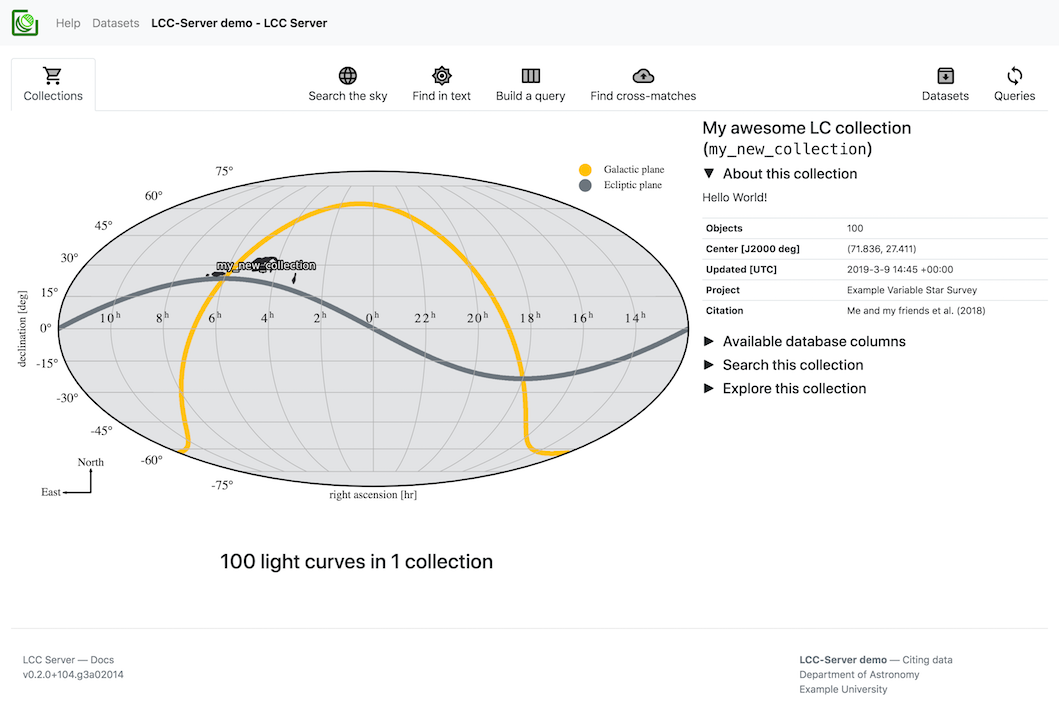

In [35]:
Image('/Users/waqasbhatti/Downloads/screencapture-localhost-12500-2019-03-09-14_52_13.png')

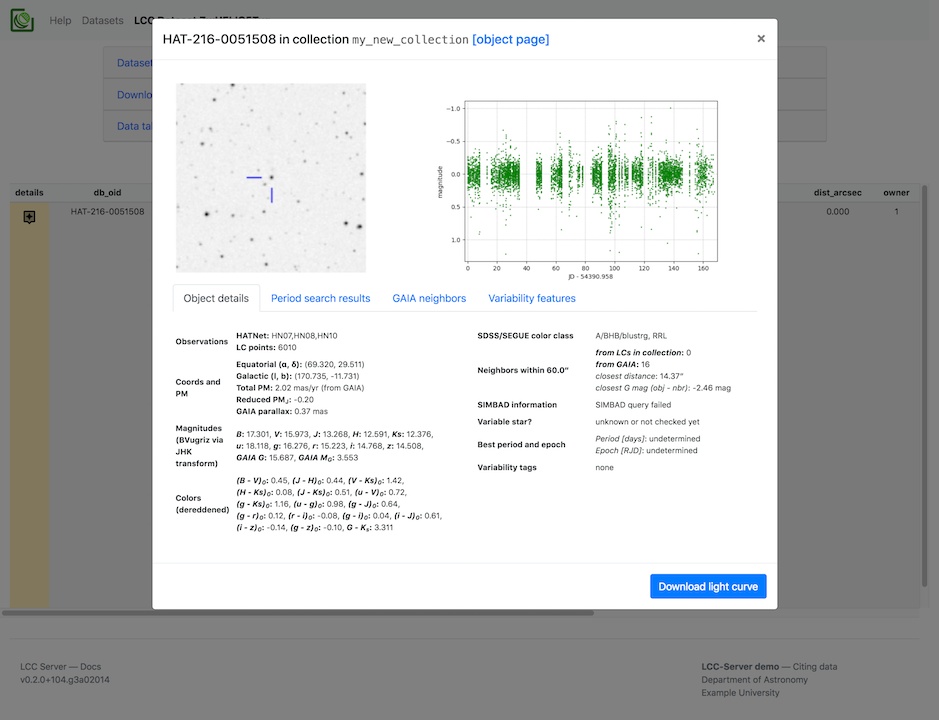

In [36]:
Image('/Users/waqasbhatti/Downloads/screencapture-localhost-12500-set-ZwUELIC5Tyg-2019-03-09-14_54_05.png')